
## Importing all the Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
import re

## Importing data using Pandas


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Train.csv')
df = df.drop(columns=['Unnamed: 0'], )

In [ ]:
df.head()

,TEXT,Label
0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,Been friends since 7th grade. Look at us now w...,2
3,This is what it looks like when someone loves ...,3
4,RT @user this white family was invited to a Bl...,3


## Pre-Processing using NLTK and re. 

* Stopword removal using NLTK                                     
* Tokenisation using re
* Removing words starting with # and @

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
corpus = list()
sw = set(stopwords.words('english'))

for i in range(70000):
    text = df['TEXT'][i]
    text = text.lower()
    text = re.findall('[a-z#@]+', text)
    text = [word for word in text if word[0] != '@' and word[0] != '#' and word not in sw]
    text = ' '.join(text)
    corpus.append(text)

### Making a dataframe using the pandas library


In [ ]:
refined_df = pd.DataFrame(corpus)
refined_df = refined_df.join(df['Label'])
refined_df.columns = ['text', 'emoji_label']
refined_df = refined_df[refined_df['text'].map(len) > 0]

In [ ]:
refined_df.head()

,text,emoji_label
0,vacation wasted port,0
1,oh wynwood funny wynwood,1
2,friends since th grade look us following dream...,2
3,looks like someone loves unconditionally oh pu...,3
4,rt white family invited black barbecue never l...,3


## Exploratory Data Analysis using matplotlib and seaborn

* using numpy to make a frequency table for every emoji
* making a bar plot using seaborn


In [ ]:
label_array = np.array(refined_df['emoji_label'])
(emojis, counts) = np.unique(label_array, return_counts=True)

In [ ]:
print(emojis)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 1555  2591  7069  6829  1876  1975  2080  4357  1990 15047  1719  2429
  1907  3245  2339  3843  2823  2748  1720  1738]


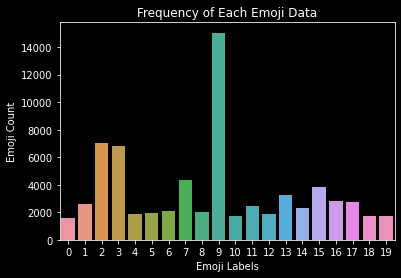

In [ ]:
plt.style.use('dark_background')
sns.barplot(x = emojis, y = counts)
plt.xlabel(xlabel='Emoji Labels')
plt.ylabel(ylabel='Emoji Count')
plt.title('Frequency of Each Emoji Data')
plt.show()

> We can obseve that the distribution is not good so we will oversample the data at a later phase


# Transfer Learning and Over-Sampling

## Importing glove which is comprised of 6 Billion words with 50 dimentions

In [ ]:
f = open("/content/drive/MyDrive/Colab Notebooks/data/glove.6B.50d.txt", encoding='utf8')

embedding_index = dict()

for line in f:
    values = line.split()
    word = values[0]
    emb = np.array(values[1:], dtype ='float')
    embedding_index[word] = emb
    

In [ ]:
print(embedding_index['apple'])

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


> You can clearly see that each word is represented as a vector of 50 numerical values


### Now we will define a function *get_embedding_output*  

> It will take a text dataframe as an input and then convert each word into a vector of 50 elements.

> As we have removed a lot of words such as stop words we will be use a maximum of 12 words per tweet.



In [ ]:
def get_embedding_output(X):
    maxLen = 12
    embedding_output = np.zeros((len(X), maxLen, 50))

    for ix in range(X.shape[0]):
        my_example = X[ix].split()
       
        for ij in range(len(my_example)):
            if (embedding_index.get(my_example[ij].lower()) is not None) and (ij < maxLen):
                embedding_output[ix][ij] = embedding_index[my_example[ij].lower()]

    return embedding_output


In [ ]:
x_train = refined_df['text'].values
y_train = refined_df['emoji_label'].values
x_train_embed = get_embedding_output(x_train)

In [ ]:
print(x_train_embed[0])

[[ 1.2875    1.2586   -0.71297  -0.15497  -0.61965  -0.80052  -2.0029
   0.41959  -0.075328 -0.21366  -0.84603  -0.082605  0.99821   0.11348
   1.6989    0.65965  -0.32471  -0.24805  -0.047889  0.081395  0.48102
   0.51665  -0.5788    0.74126   0.31082  -0.67281  -0.25039   0.22736
   1.1558    0.54096   1.5812    0.91512  -0.88902   0.52964   0.534
   0.1331   -0.51461   0.36751  -0.14438  -0.43314  -0.52991   0.48018
   0.49344   0.46789  -0.46684  -0.39633   0.1686   -0.23279   0.2212
   0.72042 ]
 [ 0.18103  -0.40867   0.43368  -0.30662   0.23923  -0.088941 -0.18667
   1.0391   -0.071017  1.0576   -0.39      0.051926 -0.47777   0.054245
   0.56796  -0.76576   0.90016  -0.29673  -0.14303  -0.37184  -0.25412
   0.044725  0.24972  -0.58401   0.66839  -0.46125   0.40017   0.12867
   0.57054  -0.3514    1.3048    1.059     0.39403  -0.10169  -0.48836
   0.7662   -0.11982   1.27      0.33597  -0.69918   0.16059   0.038067
  -0.070814  0.15741  -0.58301   0.272    -0.49875   0.29675   0.1

> Now each tweet will be an numpy array of 12 x 50

### Converting emoji_label to One Hot Vector

In [ ]:
from keras.utils import to_categorical

y_train_ohv = to_categorical(y_train)

In [ ]:
print(y_train[8])
print(y_train_ohv[8])

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Oversampling using SMOTE


In [ ]:
x_train_embed.shape

(69880, 12, 50)

In [ ]:
from imblearn.over_sampling import SMOTE

x_train_embed = x_train_embed.reshape(-1, 600)

oversample = SMOTE()
x, y = oversample.fit_resample(x_train_embed, y_train)

In [ ]:
print(x.shape)

print(y.shape)

(300940, 600)
(300940,)


> Now we will visualize and see if our data is properly sampled or not

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[15047 15047 15047 15047 15047 15047 15047 15047 15047 15047 15047 15047
 15047 15047 15047 15047 15047 15047 15047 15047]


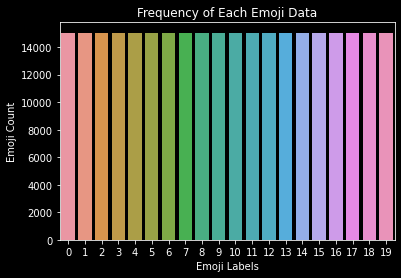

In [ ]:
(emojis, counts) = np.unique(y, return_counts=True)

print(emojis)
print(counts)

plt.style.use('dark_background')
sns.barplot(x = emojis, y = counts)
plt.xlabel(xlabel='Emoji Labels')
plt.ylabel(ylabel='Emoji Count')
plt.title('Frequency of Each Emoji Data')
plt.show()

> Now our data is properly sampled. We will reshape our data such that it gets reverted to its original values

In [ ]:
x = x.reshape((-1,12,50))

x.shape

(300940, 12, 50)

In [ ]:
y = to_categorical(y)

print(y[1])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


> Now our data is properly configured to be fed to a neural Network

# Building Model using Keras

* We initialized a Sequential Model
* Added with Bidirection LSTM with 512 cells and 256 cells
* Added Dropouts to avoid overfitting.
* Added few dense layers to tune our model.


> You can also observe that we have used *relu* for activation

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Bidirectional(
    LSTM(units = 512, return_sequences=True), input_shape = (12,50)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=20, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 12, 1024)          2306048   
_________________________________________________________________
dropout (Dropout)            (None, 12, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               2623488   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

## We are going to compile and train our model

* Doing a test-train split
* Compiling our model
* Defining Callbacks
* Fitting our model

In [ ]:
from sklearn.model_selection import train_test_split

x1, x2, y1, y2 = train_test_split(x, y, test_size=0.1, random_state=42)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

### Defining callbacks

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=3)

### Training our model with tha data and callbacks


In [ ]:
hist = model.fit(x1, y1, batch_size=64, epochs=40, callbacks=[early_stopping], shuffle=True, validation_split=0.1)

Epoch 1/40
3809/3809 [==============================] - 55s 14ms/step - loss: 2.5759 - accuracy: 0.2170 - val_loss: 2.3023 - val_accuracy: 0.3037
Epoch 2/40
3809/3809 [==============================] - 54s 14ms/step - loss: 1.9247 - accuracy: 0.4203 - val_loss: 1.5401 - val_accuracy: 0.5375
Epoch 3/40
3809/3809 [==============================] - 54s 14ms/step - loss: 1.2735 - accuracy: 0.6134 - val_loss: 1.0884 - val_accuracy: 0.6694
Epoch 4/40
3809/3809 [==============================] - 53s 14ms/step - loss: 0.9096 - accuracy: 0.7204 - val_loss: 0.8658 - val_accuracy: 0.7416
Epoch 5/40
3809/3809 [==============================] - 53s 14ms/step - loss: 0.7087 - accuracy: 0.7782 - val_loss: 0.7593 - val_accuracy: 0.7741
Epoch 6/40
3809/3809 [==============================] - 53s 14ms/step - loss: 0.5900 - accuracy: 0.8138 - val_loss: 0.6904 - val_accuracy: 0.7956
Epoch 7/40
3809/3809 [==============================] - 53s 14ms/step - loss: 0.5101 - accuracy: 0.8390 - val_loss: 0.6584 -

### Analysing our training with graphs

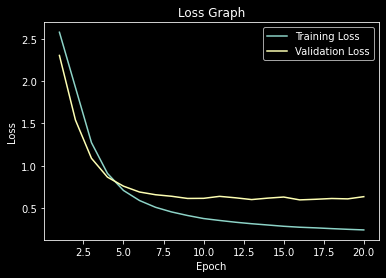

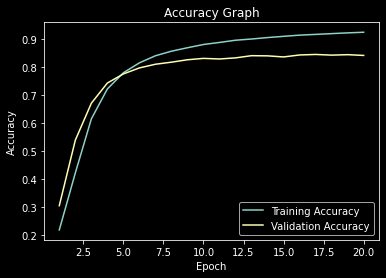

In [ ]:
acc = hist.history['accuracy']
loss = hist.history['loss']

val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()

plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

# Testing our Model

In [ ]:
model.evaluate(x2, y2, batch_size=64)

471/471 [==============================] - 3s 6ms/step - loss: 0.6162 - accuracy: 0.8436


[0.6162001490592957, 0.8435568809509277]

> That's the end of it. We have acheived 84.36% of test accuracy. YAY!!!

In [ ]:
prediction = np.argmax(model.predict(x2, batch_size=64), axis=-1)
y2 = np.array([np.where(r==1)[0][0] for r in y2])

### Confusion Matrix

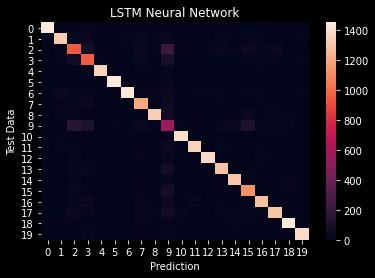

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

confusion = confusion_matrix(prediction, y2)
sns.heatmap(confusion)
plt.xlabel('Prediction')
plt.ylabel('Test Data')
plt.title('LSTM Neural Network')
plt.show()


### AUC Score

In [ ]:
prediction = model.predict(x2, batch_size=64)
y2 = to_categorical(y2)
roc_auc_score(y2, prediction, multi_class='ovo')

0.9850319646654544

> Yippee!! An AUC score of 0.9850319646654544 is acheived

## Making Predictions

> Reading the mapping file

In [ ]:
mapping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Mapping.csv')
mapping = mapping.drop('Unnamed: 0', axis=1)

emoji_map = dict()

for i in range(20):
    emoji_map[i] = mapping['emoticons'][i]

> Getting Embedding Output for a list of strings so that we can make predictions

In [ ]:
def get_predict_embedding_output(X):
    maxLen = 12
    embedding_output = np.zeros((len(X), maxLen, 50))

    for ix in range(len(X)):
        my_example = X[ix].split()
        print(my_example)
       
        for ij in range(len(my_example)):
            if (embedding_index.get(my_example[ij].lower()) is not None) and (ij < maxLen):
                embedding_output[ix][ij] = embedding_index[my_example[ij].lower()]

    return embedding_output

> Testing our function on some data

In [ ]:
Z = ['I love you', 'I am really surprised', 'It\'s hilarious']

X = list()

for iz in range(len(Z)):
    z = Z[iz]
    z = z.lower()
    z = re.findall('[a-z]+', z)
    z = [word for word in z if word not in sw]
    z = ' '.join(z)
    X.append(z)

X = get_predict_embedding_output(X)

result = model.predict(X)

for ix in range(len(X)):
    print(emoji_map[np.argmax(result[ix])])

['love']
['really', 'surprised']
['hilarious']
😘
🔥
😂


> Here You can see some real emoticons as outputs.

## Making some realtime Predictions

> Let the Magic Begin :p

In [ ]:
def predict(text):
    ot = text
    
    text = text.lower()
    text = re.findall('[a-z]+', text)
    text = [word for word in text if word not in sw]
    
    embedding_output = np.zeros((1, 12, 50))
        
    for ij in range(len(text)):
        if (embedding_index.get(text[ij]) is not None) and (ij < 12):
            embedding_output[0][ij] = embedding_index[text[ij]]

    res = np.argmax(model.predict(embedding_output))

    return ot + ' ' + emoji_map[res]


> Well this predict function takes in a string and then it attaches an emoji to the end.

In [ ]:
print(predict('it was funny lol'))

print(predict('I love you'))

print(predict('Congrats on your big success'))

it was funny lol 😂
I love you 😘
Congrats on your big success ❤


> Now you have seen our complete code in action. 

---
# The End


---
    Project By:
    Rohit, Ritwik Ranjan and Saarthak Jain
---

    







